<a href="https://colab.research.google.com/github/ngonam2403/VEF-Final-Project_202007/blob/master/VEF_Home_Credit_Trang.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Import and Read Data

### Import

In [ ]:
import pandas as pd
import numpy as np
# !pip install pymysql
# import pymysql
import seaborn as sns
import matplotlib.pyplot as plt
# !pip install sklearn
from sklearn.preprocessing import LabelEncoder

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


### Read in Data

In [ ]:
import os
os.getcwd()
os.listdir()
from google.colab import drive 
drive.mount('/content/gdrive')
#chuyển về thư mục data bên trong Google Drive.
os.chdir('/content/gdrive/My Drive/VEF')
os.getcwd()
os.listdir()

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


['application_train.csv', 'application_test.csv', 'log_reg_baseline.csv']

In [ ]:
app_train = pd.read_csv('application_train.csv')
app_test = pd.read_csv('application_test.csv')
print('Training data shape : ', app_train.shape)
app_train.head(5)
app_test.head(5)

Training data shape :  (307511, 122)


,SK_ID_CURR,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,...,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,FONDKAPREMONT_MODE,HOUSETYPE_MODE,TOTALAREA_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100001,Cash loans,F,N,Y,0,135000.0,568800.0,20560.5,450000.0,Unaccompanied,Working,Higher education,Married,House / apartment,0.018850,-19241,-2329,-5170.0,-812,NaN,1,1,0,1,0,1,NaN,2.0,2,2,TUESDAY,18,0,0,0,0,0,0,Kindergarten,...,NaN,0.0514,NaN,NaN,NaN,block of flats,0.0392,"Stone, brick",No,0.0,0.0,0.0,0.0,-1740.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
1,100005,Cash loans,M,N,Y,0,99000.0,222768.0,17370.0,180000.0,Unaccompanied,Working,Secondary / secondary special,Married,House / apartment,0.035792,-18064,-4469,-9118.0,-1623,NaN,1,1,0,1,0,0,Low-skill Laborers,2.0,2,2,FRIDAY,9,0,0,0,0,0,0,Self-employed,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,3.0
2,100013,Cash loans,M,Y,Y,0,202500.0,663264.0,69777.0,630000.0,NaN,Working,Higher education,Married,House / apartment,0.019101,-20038,-4458,-2175.0,-3503,5.0,1,1,0,1,0,0,Drivers,2.0,2,2,MONDAY,14,0,0,0,0,0,0,Transport: type 3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,-856.0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,1.0,4.0
3,100028,Cash loans,F,N,Y,2,315000.0,1575000.0,49018.5,1575000.0,Unaccompanied,Working,Secondary / secondary special,Married,House / apartment,0.026392,-13976,-1866,-2000.0,-4208,NaN,1,1,0,1,1,0,Sales staff,4.0,2,2,WEDNESDAY,11,0,0,0,0,0,0,Business Entity Type 3,...,0.2446,0.3739,0.0388,0.0817,reg oper account,block of flats,0.3700,Panel,No,0.0,0.0,0.0,0.0,-1805.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,3.0
4,100038,Cash loans,M,Y,N,1,180000.0,625500.0,32067.0,625500.0,Unaccompanied,Working,Secondary / secondary special,Married,House / apartment,0.010032,-13040,-2191,-4000.0,-4262,16.0,1,1,1,1,0,0,NaN,3.0,2,2,FRIDAY,5,0,0,0,0,1,1,Business Entity Type 3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,-821.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN


## General View

### Description

In [ ]:
app_train['TARGET'].value_counts()

0    282686
1     24825
Name: TARGET, dtype: int64

In [ ]:
app_train.dtypes.value_counts()

float64    65
int64      41
object     16
dtype: int64

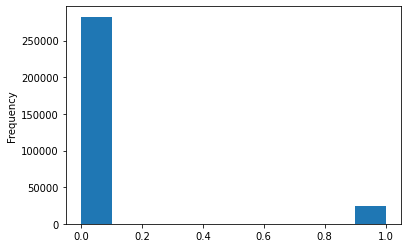

In [ ]:
app_train['TARGET'].astype(int).plot.hist();

### Missing values

In [ ]:
"""
FUNCTION: CHECK MISSING DATA
input: a dataframe MxN --> output: a dataframe Nx2
need: pandas
"""
def create_table_missing_values(df):
    mis_val = df.isnull().sum() #total missing values #input: df MxN -> output: df Nx2
    mis_val_percent = 100 * df.isnull().sum() / len(df) #percentage of missing values #input: df MxN -> output: df Nx2
    mis_val_table = pd.concat( #join df mis_val and df mis_val_percent
        [mis_val, mis_val_percent], 
        axis=1
        ) 
    mis_val_table_ren_columns = mis_val_table.rename( #rename the columns
        columns = {
            0 : 'Missing values', 
            1 : '% of Total Values'
            }
        )
    mis_val_table_ren_columns = mis_val_table_ren_columns[ #sort the table by percentage of missing descending
        mis_val_table_ren_columns.iloc[:,1] != 0].sort_values('% of Total Values',ascending=False).round(1) #exclude those has 0% missing
  
    print("Your selected dataframe has ")    
    return mis_val_table_ren_columns

In [ ]:
create_table_missing_values=create_table_missing_values(app_train)
create_table_missing_values.head(10)

Your selected dataframe has 


,Missing values,% of Total Values
COMMONAREA_MEDI,214865,69.9
COMMONAREA_AVG,214865,69.9
COMMONAREA_MODE,214865,69.9
NONLIVINGAPARTMENTS_MEDI,213514,69.4
NONLIVINGAPARTMENTS_MODE,213514,69.4
NONLIVINGAPARTMENTS_AVG,213514,69.4
FONDKAPREMONT_MODE,210295,68.4
LIVINGAPARTMENTS_MODE,210199,68.4
LIVINGAPARTMENTS_MEDI,210199,68.4
LIVINGAPARTMENTS_AVG,210199,68.4


### Label Encoding and One-Hot Encoding

In [ ]:
# Với biến chỉ có 2 giá trị, dùng label encoding, nếu nhiều hơn thì chuyển sang encoding rồi dùng one-hot encoding 
# Create a label encoder object
le = LabelEncoder()
le_count = 0

# Iterate through the columns
for col in app_train:
    if app_train[col].dtype == 'object':
        # If 2 or fewer unique categories
        if len(list(app_train[col].unique())) <= 2:
            # Train on the training data
            le.fit(app_train[col])
            # Transform both training and testing data
            app_train[col] = le.transform(app_train[col])
            app_test[col] = le.transform(app_test[col])
            
            # Keep track of how many columns were label encoded
            le_count += 1
            
            
print('%d columns were label encoded.' % le_count)

3 columns were label encoded.


In [ ]:
# apply one-hot encoding với các biến đã dùng label encoding, trong pd dùng get_dummies, trong scikit learn là one hot encoding
#one-hot encoding of categorical variables
app_train = pd.get_dummies(app_train)
app_test = pd.get_dummies(app_test)

print('Training Features shape: ', app_train.shape)
print('Testing Features shape: ', app_test.shape)

Training Features shape:  (307511, 243)
Testing Features shape:  (48744, 239)


### Aligning Training and Testing Data

In [ ]:
train_labels = app_train['TARGET']

# Align the training and testing data, keep only columns present in both dataframes
app_train, app_test = app_train.align(app_test, join = 'inner', axis = 1)

# Add the target back in
app_train['TARGET'] = train_labels

print('Training Features shape: ', app_train.shape)
print('Testing Features shape: ', app_test.shape)

Training Features shape:  (307511, 240)
Testing Features shape:  (48744, 239)


Gộp app_train và test_train, chỉ giữ những cột 2 df đều có

### Correlation

In [ ]:
"""FUNTION: top 10 correlation with Target and bottom 10 correlation
input: a dataframe MxN --> output: a dataframe Nx2
need: pandas
"""
def create_table_top_corr(df, target_col_name):
    correlations = df.corr()[target_col_name].sort_values()

    print('Most Positive Correlations:\n', correlations.tail(10))
    print('\nMost Negative Correlations:\n', correlations.head(10))


In [ ]:
create_table_top_corr(app_train,'TARGET')

Most Positive Correlations:
 NAME_EDUCATION_TYPE_Secondary / secondary special    0.049824
REG_CITY_NOT_WORK_CITY                               0.050994
DAYS_ID_PUBLISH                                      0.051457
CODE_GENDER_M                                        0.054713
DAYS_LAST_PHONE_CHANGE                               0.055218
NAME_INCOME_TYPE_Working                             0.057481
REGION_RATING_CLIENT                                 0.058899
REGION_RATING_CLIENT_W_CITY                          0.060893
DAYS_BIRTH                                           0.078239
TARGET                                               1.000000
Name: TARGET, dtype: float64

Most Negative Correlations:
 EXT_SOURCE_3                           -0.178919
EXT_SOURCE_2                           -0.160472
EXT_SOURCE_1                           -0.155317
NAME_EDUCATION_TYPE_Higher education   -0.056593
CODE_GENDER_F                          -0.054704
NAME_INCOME_TYPE_Pensioner             -0.04620

In [ ]:
"""FUNTION: top 10 correlation with Target and bottom 10 correlation
input: a dataframe MxN --> output: a dataframe Nx2
need: pandas
"""
def create_table_top_corr_spearman(df, target_col_name):
    correlations = df.corr(method='spearman')[target_col_name].sort_values()

    print('Most Positive Correlations:\n', correlations.tail(10))
    print('\nMost Negative Correlations:\n', correlations.head(10))

In [ ]:
create_table_top_corr_spearman(app_train,'TARGET')

Most Positive Correlations:
 REG_CITY_NOT_LIVE_CITY         0.044395
FLAG_EMP_PHONE                 0.045982
REG_CITY_NOT_WORK_CITY         0.050994
DAYS_ID_PUBLISH                0.052535
OWN_CAR_AGE                    0.052932
DAYS_LAST_PHONE_CHANGE         0.053711
REGION_RATING_CLIENT           0.058909
REGION_RATING_CLIENT_W_CITY    0.060936
DAYS_BIRTH                     0.078328
TARGET                         1.000000
Name: TARGET, dtype: float64

Most Negative Correlations:
 EXT_SOURCE_3      -0.166330
EXT_SOURCE_1      -0.151128
EXT_SOURCE_2      -0.147332
FLOORSMAX_AVG     -0.046178
FLOORSMAX_MEDI    -0.046019
FLOORSMAX_MODE    -0.045357
LIVINGAREA_AVG    -0.041631
LIVINGAREA_MEDI   -0.041140
TOTALAREA_MODE    -0.040071
LIVINGAREA_MODE   -0.039060
Name: TARGET, dtype: float64


## EDA

### Description

In [ ]:
app_train_gr=app_train[['TARGET','DAYS_BIRTH','EXT_SOURCE_3','EXT_SOURCE_2','EXT_SOURCE_1','REGION_RATING_CLIENT_W_CITY','REGION_RATING_CLIENT','NAME_EDUCATION_TYPE_Higher education','NAME_INCOME_TYPE_Working','CODE_GENDER_F','DAYS_EMPLOYED','DAYS_LAST_PHONE_CHANGE','CNT_CHILDREN']]

In [ ]:
app_train_gr.describe()

,TARGET,DAYS_BIRTH,EXT_SOURCE_3,EXT_SOURCE_2,EXT_SOURCE_1,REGION_RATING_CLIENT_W_CITY,REGION_RATING_CLIENT,NAME_EDUCATION_TYPE_Higher education,NAME_INCOME_TYPE_Working,CODE_GENDER_F,DAYS_EMPLOYED,DAYS_LAST_PHONE_CHANGE,CNT_CHILDREN
count,307511.000000,307511.000000,246546.000000,3.068510e+05,134133.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307510.000000,307511.000000
mean,0.080729,-16036.995067,0.510853,5.143927e-01,0.502130,2.031521,2.052463,0.243448,0.516320,0.658344,63815.045904,-962.858788,0.417052
std,0.272419,4363.988632,0.194844,1.910602e-01,0.211062,0.502737,0.509034,0.429164,0.499734,0.474266,141275.766519,826.808487,0.722121
min,0.000000,-25229.000000,0.000527,8.173617e-08,0.014568,1.000000,1.000000,0.000000,0.000000,0.000000,-17912.000000,-4292.000000,0.000000
25%,0.000000,-19682.000000,0.370650,3.924574e-01,0.334007,2.000000,2.000000,0.000000,0.000000,0.000000,-2760.000000,-1570.000000,0.000000
50%,0.000000,-15750.000000,0.535276,5.659614e-01,0.505998,2.000000,2.000000,0.000000,1.000000,1.000000,-1213.000000,-757.000000,0.000000
75%,0.000000,-12413.000000,0.669057,6.636171e-01,0.675053,2.000000,2.000000,0.000000,1.000000,1.000000,-289.000000,-274.000000,1.000000
max,1.000000,-7489.000000,0.896010,8.549997e-01,0.962693,3.000000,3.000000,1.000000,1.000000,1.000000,365243.000000,0.000000,19.000000


In [ ]:
print (app_train_gr.isnull().sum()) #check missing data của nhóm chọn

TARGET                                       0
DAYS_BIRTH                                   0
EXT_SOURCE_3                             60965
EXT_SOURCE_2                               660
EXT_SOURCE_1                            173378
REGION_RATING_CLIENT_W_CITY                  0
REGION_RATING_CLIENT                         0
NAME_EDUCATION_TYPE_Higher education         0
NAME_INCOME_TYPE_Working                     0
CODE_GENDER_F                                0
DAYS_EMPLOYED                                0
DAYS_LAST_PHONE_CHANGE                       1
CNT_CHILDREN                                 0
dtype: int64


In [ ]:
app_train_gr.corr()

,TARGET,DAYS_BIRTH,EXT_SOURCE_3,EXT_SOURCE_2,EXT_SOURCE_1,REGION_RATING_CLIENT_W_CITY,REGION_RATING_CLIENT,NAME_EDUCATION_TYPE_Higher education,NAME_INCOME_TYPE_Working,CODE_GENDER_F,DAYS_EMPLOYED,DAYS_LAST_PHONE_CHANGE,CNT_CHILDREN
TARGET,1.000000,0.078239,-0.178919,-0.160472,-0.155317,0.060893,0.058899,-0.056593,0.057481,-0.054704,-0.044932,0.055218,0.019187
DAYS_BIRTH,0.078239,1.000000,-0.205478,-0.091996,-0.600610,0.008073,0.009361,0.115808,0.304568,-0.148074,-0.615864,0.082939,0.330938
EXT_SOURCE_3,-0.178919,-0.205478,1.000000,0.109167,0.186846,-0.012158,-0.012903,-0.022429,-0.065618,0.023066,0.113434,-0.075256,-0.042710
EXT_SOURCE_2,-0.160472,-0.091996,0.109167,1.000000,0.213982,-0.288299,-0.292895,0.124581,-0.067782,0.014611,-0.020767,-0.195764,-0.018015
EXT_SOURCE_1,-0.155317,-0.600610,0.186846,0.213982,1.000000,-0.115374,-0.115341,0.135180,-0.186366,0.306729,0.289848,-0.132607,-0.138470
REGION_RATING_CLIENT_W_CITY,0.060893,0.008073,-0.012158,-0.288299,-0.115374,1.000000,0.950842,-0.067580,0.093937,0.017276,0.034624,0.025717,0.024781
REGION_RATING_CLIENT,0.058899,0.009361,-0.012903,-0.292895,-0.115341,0.950842,1.000000,-0.065014,0.102809,0.017874,0.032750,0.026022,0.025423
NAME_EDUCATION_TYPE_Higher education,-0.056593,0.115808,-0.022429,0.124581,0.135180,-0.067580,-0.065014,1.000000,-0.074165,0.016031,-0.104191,-0.006281,0.033654
NAME_INCOME_TYPE_Working,0.057481,0.304568,-0.065618,-0.067782,-0.186366,0.093937,0.102809,-0.074165,1.000000,-0.106294,-0.483907,0.007111,0.136604
CODE_GENDER_F,-0.054704,-0.148074,0.023066,0.014611,0.306729,0.017276,0.017874,0.016031,-0.106294,1.000000,0.156015,-0.025286,-0.047394


### Histogram

In [ ]:
"""FUNCTION: plot histogram"""
def create_plot_histogram(df,col_name,titleName,xlabelName):
    df[col_name].plot.hist(title = titleName)
    plt.xlabel(xlabelName)
"""example
plot_histogram(df = data,
               col_name = 'DAYS_EMPLOYED',
               titleName = 'Days Employment Histogram',
               xlabelName = 'Days Employment')
"""               

"example\nplot_histogram(df = data,\n               col_name = 'DAYS_EMPLOYED',\n               titleName = 'Days Employment Histogram',\n               xlabelName = 'Days Employment')\n"

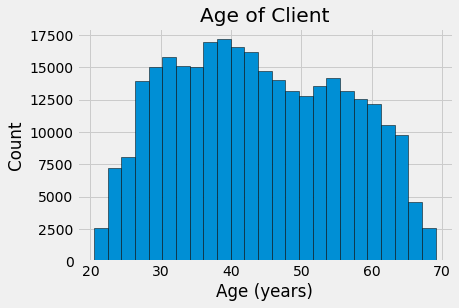

In [ ]:
# Set the style of plots
plt.style.use('fivethirtyeight')

# Plot the distribution of ages in years
plt.hist(app_train['DAYS_BIRTH'] /- 365, edgecolor = 'k', bins = 25)
plt.title('Age of Client'); plt.xlabel('Age (years)'); plt.ylabel('Count');

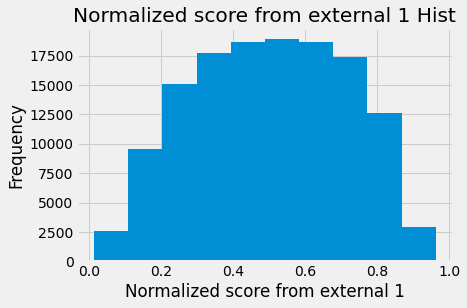

In [ ]:
create_plot_histogram(app_train,'EXT_SOURCE_1','Normalized score from external 1 Hist', 'Normalized score from external 1' )

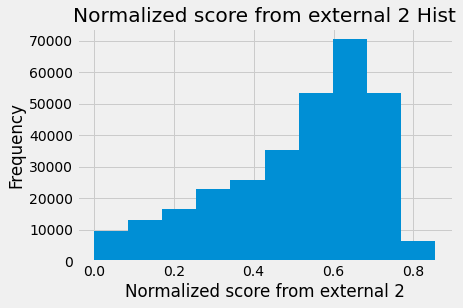

In [ ]:
create_plot_histogram(app_train,'EXT_SOURCE_2','Normalized score from external 2 Hist', 'Normalized score from external 2' )

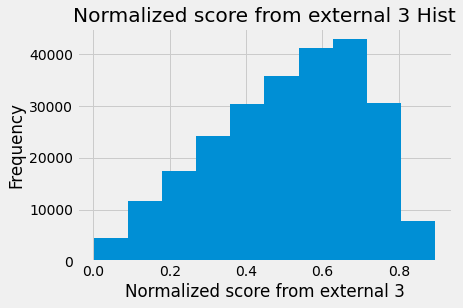

In [ ]:
create_plot_histogram(app_train,'EXT_SOURCE_3','Normalized score from external 3 Hist', 'Normalized score from external 3' )

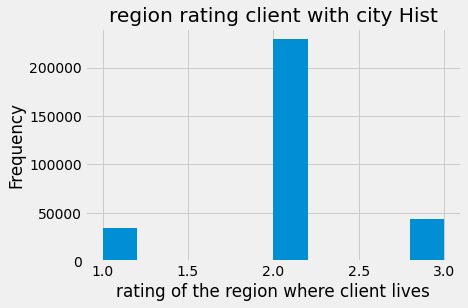

In [ ]:
create_plot_histogram(app_train,'REGION_RATING_CLIENT_W_CITY','region rating client with city Hist', 'rating of the region where client lives' )

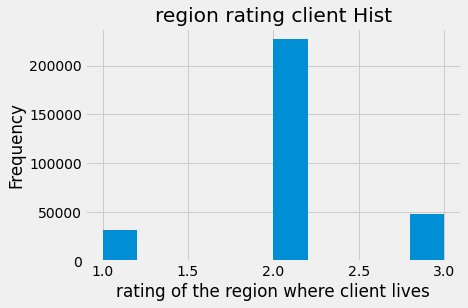

In [ ]:
create_plot_histogram(app_train,'REGION_RATING_CLIENT','region rating client Hist', 'rating of the region where client lives' )

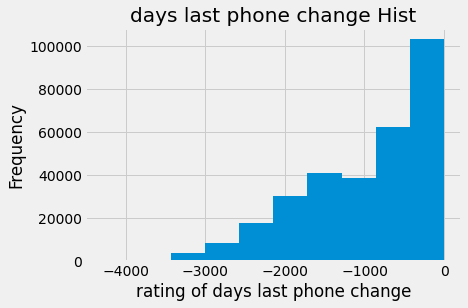

In [ ]:
create_plot_histogram(app_train,'DAYS_LAST_PHONE_CHANGE','days last phone change Hist', 'rating of days last phone change' )

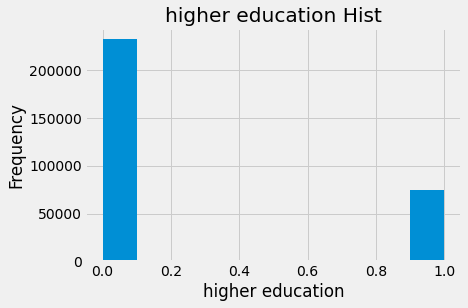

In [ ]:
create_plot_histogram(app_train_gr,'NAME_EDUCATION_TYPE_Higher education','higher education Hist', 'higher education' )

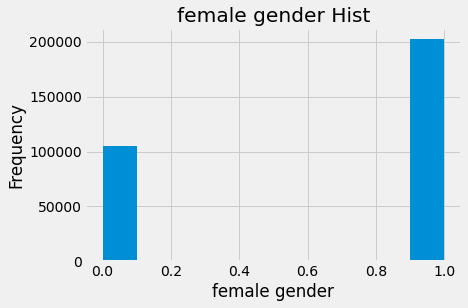

In [ ]:
create_plot_histogram(app_train,'CODE_GENDER_F','female gender Hist', 'female gender' )

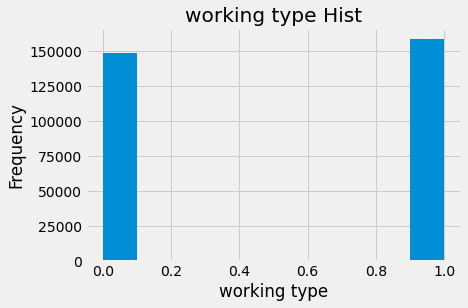

In [ ]:
create_plot_histogram(app_train,'NAME_INCOME_TYPE_Working','working type Hist', 'working type' )

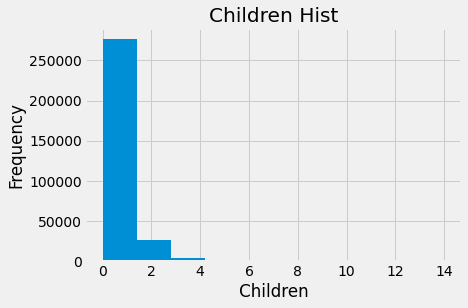

In [ ]:

# Hist với bất thường thay bằng na
app_train['CNT_CHILDREN'].replace({19: np.nan}, inplace = True)

app_train['CNT_CHILDREN'].plot.hist(title = 'Children Hist');
plt.xlabel('Children');

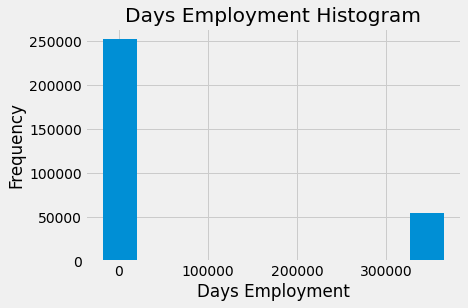

In [ ]:
app_train['DAYS_EMPLOYED'].replace({365243: np.nan}, inplace = True)
create_plot_histogram(app_train,'DAYS_EMPLOYED','Days Employment Histogram', 'Days Employment' )

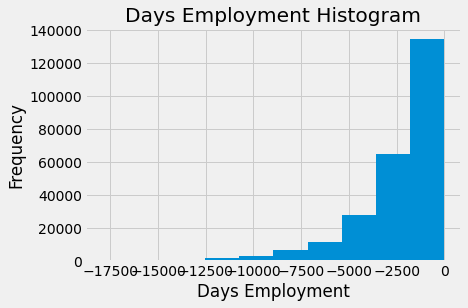

In [ ]:

# Hist với bất thường thay bằng na
app_train['DAYS_EMPLOYED'].replace({365243: np.nan}, inplace = True)

app_train['DAYS_EMPLOYED'].plot.hist(title = 'Days Employment Histogram');
plt.xlabel('Days Employment');

### KDE

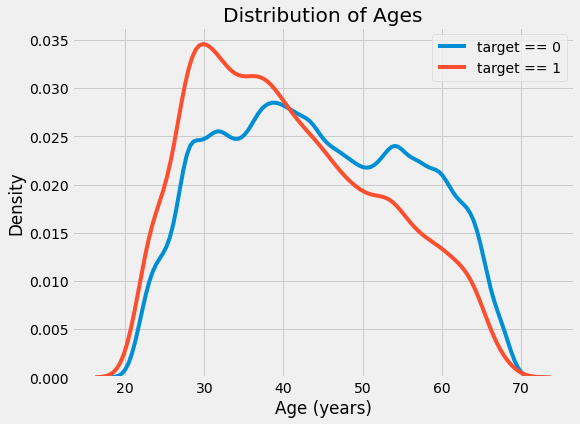

In [ ]:
plt.figure(figsize = (8, 6))

# KDE plot of loans that were repaid on time
sns.kdeplot(app_train.loc[app_train['TARGET'] == 0, 'DAYS_BIRTH'] /- 365, label = 'target == 0')

# KDE plot of loans which were not repaid on time
sns.kdeplot(app_train.loc[app_train['TARGET'] == 1, 'DAYS_BIRTH'] /- 365, label = 'target == 1')

# Labeling of plot
plt.xlabel('Age (years)'); plt.ylabel('Density'); plt.title('Distribution of Ages');

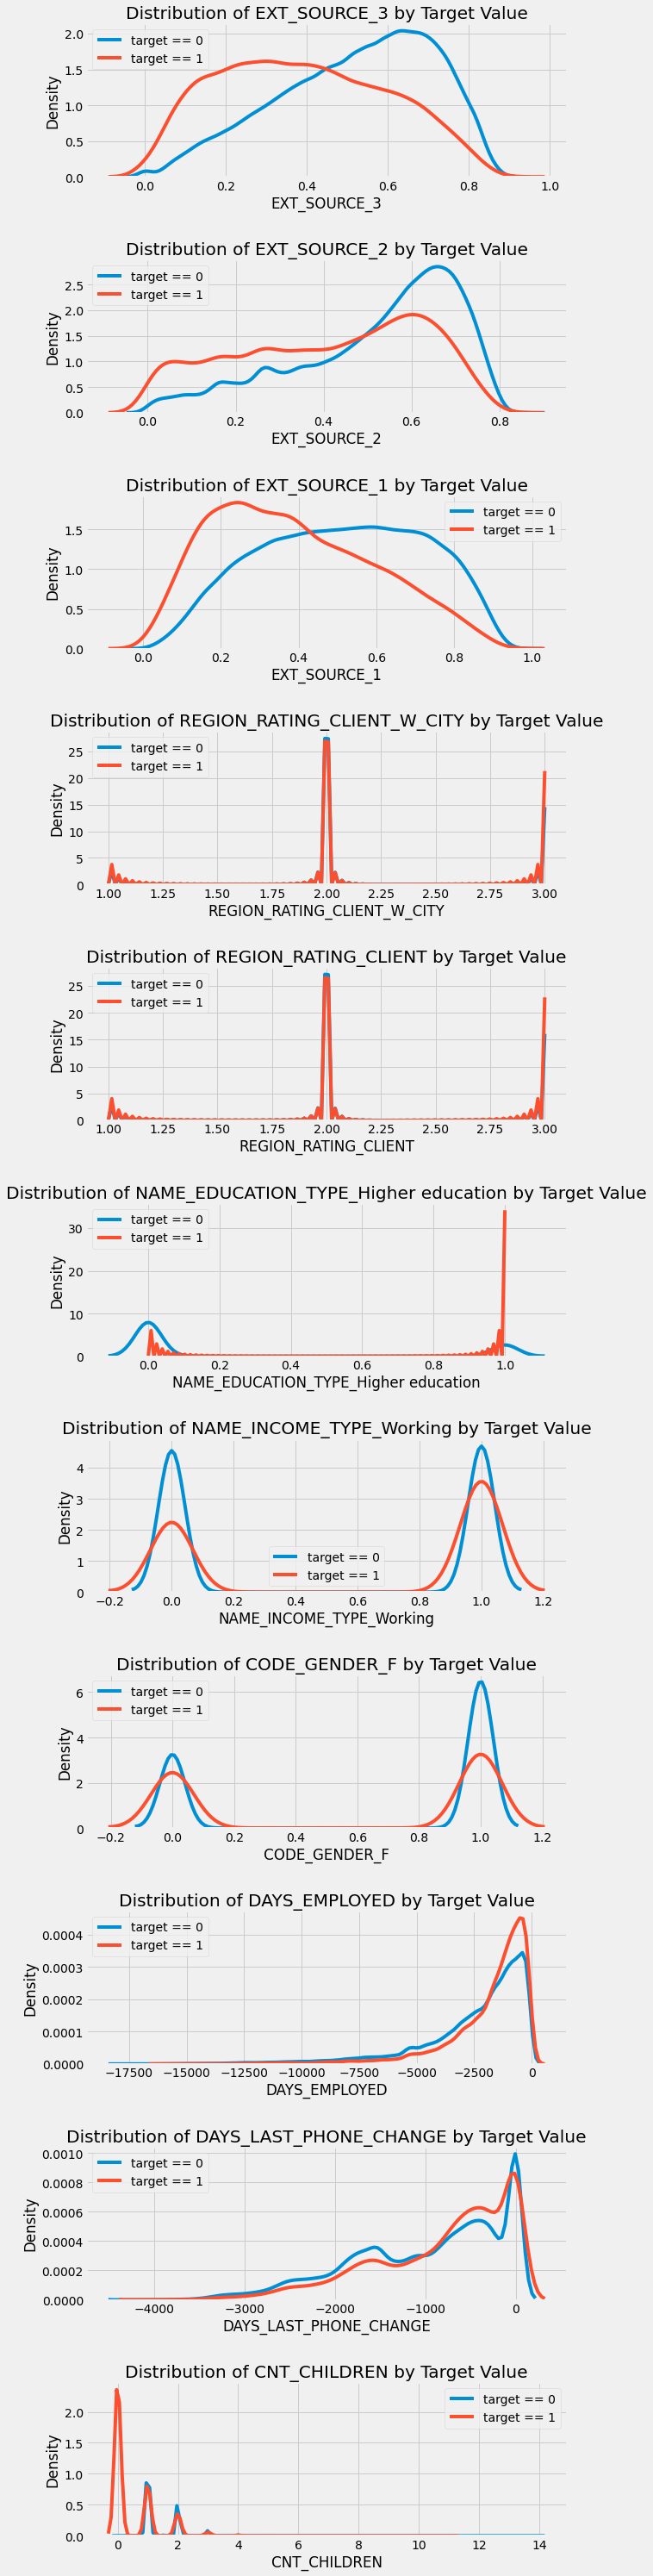

In [ ]:
plt.figure(figsize = (10, 45))

# iterate through the sources
for i, source in enumerate(['EXT_SOURCE_3','EXT_SOURCE_2','EXT_SOURCE_1','REGION_RATING_CLIENT_W_CITY','REGION_RATING_CLIENT','NAME_EDUCATION_TYPE_Higher education','NAME_INCOME_TYPE_Working','CODE_GENDER_F','DAYS_EMPLOYED','DAYS_LAST_PHONE_CHANGE','CNT_CHILDREN']):
    
    # create a new subplot for each source
    plt.subplot(12, 1, i + 1)
    # plot repaid loans
    sns.kdeplot(app_train.loc[app_train['TARGET'] == 0, source], label = 'target == 0')
    # plot loans that were not repaid
    sns.kdeplot(app_train.loc[app_train['TARGET'] == 1, source], label = 'target == 1')
    
    # Label the plots
    plt.title('Distribution of %s by Target Value' % source)
    plt.xlabel('%s' % source); plt.ylabel('Density');
    
plt.tight_layout(h_pad = 2.5)

## Model

### Imputer

In [ ]:
#prepare some function that we need to use later.
def print_object_status(df):
  """capture object change"""
  
  print(df.shape)
  print(type(df))

In [ ]:
from sklearn.preprocessing import MinMaxScaler 
from sklearn.impute import SimpleImputer as Imputer


# Drop the target from the training data
if 'TARGET' in app_train:
    train = app_train.drop(columns = ['TARGET'])
else:
    train = app_train.copy()
    
print_object_status(train)
print_object_status(app_train)

(307511, 239)
<class 'pandas.core.frame.DataFrame'>
(307511, 240)
<class 'pandas.core.frame.DataFrame'>


In [ ]:
# Feature names
features = list(train.columns)

# # Copy of the testing data
# test = app_test.copy()

# Median imputation of missing values
imputer = Imputer(strategy = 'median')

# Scale each feature to 0-1
scaler = MinMaxScaler(feature_range = (0, 1))

In [ ]:
# Fit on the training data
imputer.fit(train)

# Transform both training and testing data
train_imputed = imputer.transform(train)
# test = imputer.transform(app_test)

# Repeat with the scaler
scaler.fit(train_imputed)
train_imputed_scaled = scaler.transform(train_imputed)
# test = scaler.transform(test)

# print('Training data shape: ', train.shape)
# print('Testing data shape: ', test.shape)

print_object_status(train)
print_object_status(train_imputed)
print_object_status(train_imputed_scaled)

(307511, 239)
<class 'pandas.core.frame.DataFrame'>
(307511, 239)
<class 'numpy.ndarray'>
(307511, 239)
<class 'numpy.ndarray'>


### Split

In [ ]:
# Split X and y into training and testing sets
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test=train_test_split(
                                          train_imputed_scaled,
                                          train_labels,
                                          test_size=0.25,
                                          random_state=0)

In [ ]:
print_object_status(X_train)
print_object_status(y_train)
print_object_status(X_test)
print_object_status(y_test)

(230633, 239)
<class 'numpy.ndarray'>
(230633,)
<class 'pandas.core.series.Series'>
(76878, 239)
<class 'numpy.ndarray'>
(76878,)
<class 'pandas.core.series.Series'>


### Logistic Regression

In [ ]:
# C =0.0001
from sklearn.linear_model import LogisticRegression

# Make the model with the specified regularization parameter
log_reg = LogisticRegression(C = 0.0001)

# Train on the training data
log_reg.fit(X_train, y_train)

y_pred = log_reg.predict(X_test)


# 1. F1-score
from sklearn.metrics import f1_score
# f1_score(
#       y_test, 
#       y_pred, 
#       average='weighted')
print("F1 Score_w:", f1_score(
      y_test, 
      y_pred, 
      average='weighted'))
print("F1 Score_ma:", f1_score(
      y_test, 
      y_pred, 
      average='macro'))
print("F1 Score_mi:", f1_score(
      y_test, 
      y_pred, 
      average='micro'))

#2. AUC RUC
Y_pred_proba = log_reg.predict_proba(X_test)[:,1]
from sklearn import metrics
from sklearn.metrics import roc_auc_score
score = metrics.roc_auc_score(y_test, Y_pred_proba)
print(score)

F1 Score_w: 0.8827899156693721
F1 Score_ma: 0.4793756137202452
F1 Score_mi: 0.9207705715549311
0.6842317750572169


In [ ]:
# C =1
from sklearn.linear_model import LogisticRegression

# Make the model with the specified regularization parameter
log_reg = LogisticRegression(C = 1)

# Train on the training data
log_reg.fit(X_train, y_train)

y_pred = log_reg.predict(X_test)


# 1. F1-score
from sklearn.metrics import f1_score
# f1_score(
#       y_test, 
#       y_pred, 
#       average='weighted')
print("F1 Score_w:", f1_score(
      y_test, 
      y_pred, 
      average='weighted'))
print("F1 Score_ma:", f1_score(
      y_test, 
      y_pred, 
      average='macro'))
print("F1 Score_mi:", f1_score(
      y_test, 
      y_pred, 
      average='micro'))

#2. AUC RUC
Y_pred_proba = log_reg.predict_proba(X_test)[:,1]
from sklearn import metrics
from sklearn.metrics import roc_auc_score
score = metrics.roc_auc_score(y_test, Y_pred_proba)
print(score)

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


F1 Score_w: 0.8843241604265349
F1 Score_ma: 0.4897382526420196
F1 Score_mi: 0.9206014724628633
0.7438091210743322


In [ ]:
# C = 1000
from sklearn.linear_model import LogisticRegression

# Make the model with the specified regularization parameter
log_reg = LogisticRegression(C = 1000)

# Train on the training data
log_reg.fit(X_train, y_train)

y_pred = log_reg.predict(X_test)


# 1. F1-score
from sklearn.metrics import f1_score
# f1_score(
#       y_test, 
#       y_pred, 
#       average='weighted')
print("F1 Score_w:", f1_score(
      y_test, 
      y_pred, 
      average='weighted'))
print("F1 Score_ma:", f1_score(
      y_test, 
      y_pred, 
      average='macro'))
print("F1 Score_mi:", f1_score(
      y_test, 
      y_pred, 
      average='micro'))

#2. AUC RUC
Y_pred_proba = log_reg.predict_proba(X_test)[:,1]
from sklearn import metrics
from sklearn.metrics import roc_auc_score
score = metrics.roc_auc_score(y_test, Y_pred_proba)
print(score)

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


F1 Score_w: 0.8845176262625969
F1 Score_ma: 0.49071461401723276
F1 Score_mi: 0.9206925258201306
0.7440654924276693


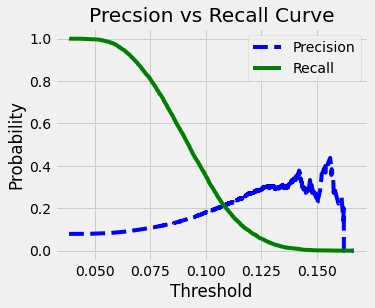

In [ ]:
from sklearn.metrics import precision_recall_curve
prec, rec, thres = precision_recall_curve(y_test, Y_pred_proba)

def _plot_prec_rec_curve(prec, rec, thres):
    plt.figure(figsize = (5, 4))
    plt.plot(thres, prec[:-1], 'b--', label = 'Precision')
    plt.plot(thres, rec[:-1], 'g-', label = 'Recall')
    plt.xlabel('Threshold')
    plt.ylabel('Probability')
    plt.title('Precsion vs Recall Curve')
    plt.legend()

_plot_prec_rec_curve(prec, rec, thres)

### Random Forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier

# Make the random forest classifier
random_forest = RandomForestClassifier(n_estimators = 100, random_state = 50, verbose = 1, n_jobs = -1)

In [ ]:
# Train on the training data
random_forest.fit(X_train, y_train)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   46.3s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  1.8min finished


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=-1, oob_score=False, random_state=50, verbose=1,
                       warm_start=False)

In [ ]:
# Make predictions on the test data
y_pred = random_forest.predict(X_test)

[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    1.1s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    2.3s finished


In [ ]:
  df_confusion_matrix = metrics.confusion_matrix(y_test, y_pred)
  print(df_confusion_matrix)

[[70786     1]
 [ 6084     7]]


In [ ]:

# F1-score
from sklearn.metrics import f1_score
# f1_score(
#       y_test, 
#       y_pred, 
#       average='weighted')
print("F1 Score_w:", f1_score(
      y_test, 
      y_pred, 
      average='weighted'))
print("F1 Score_ma:", f1_score(
      y_test, 
      y_pred, 
      average='macro'))
print("F1 Score_mi:", f1_score(
      y_test, 
      y_pred, 
      average='micro'))

F1 Score_w: 0.8830325400003962
F1 Score_ma: 0.480705795006013
F1 Score_mi: 0.9208486172897318


In [ ]:
Y_pred_proba = random_forest.predict_proba(X_test)[:,1]

[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    1.0s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    2.3s finished


In [ ]:
# 2.roc auc
from sklearn.metrics import roc_auc_score
score = metrics.roc_auc_score(y_test, Y_pred_proba)
print(score)

0.7102730133651327


## Applying models for top 10 features

In [ ]:

# Drop the target from the training data
if 'TARGET' in app_train_gr:
    train_gr = app_train_gr.drop(columns = ['TARGET'])
else:
    train_gr = app_train_gr.copy()
    
print_object_status(train_gr)
print_object_status(app_train_gr)

(307511, 12)
<class 'pandas.core.frame.DataFrame'>
(307511, 13)
<class 'pandas.core.frame.DataFrame'>


In [ ]:
# Feature names
features = list(train_gr.columns)


# Median imputation of missing values
imputer = Imputer(strategy = 'median')

# Scale each feature to 0-1
scaler = MinMaxScaler(feature_range = (0, 1))

In [ ]:
# Fit on the training data
imputer.fit(train_gr)

# Transform both training and testing data
train_gr_imputed = imputer.transform(train_gr)
# test = imputer.transform(app_test)

# Repeat with the scaler
scaler.fit(train_gr_imputed)
train_gr_imputed_scaled = scaler.transform(train_gr_imputed)

print_object_status(train_gr)
print_object_status(train_gr_imputed)
print_object_status(train_gr_imputed_scaled)

(307511, 12)
<class 'pandas.core.frame.DataFrame'>
(307511, 12)
<class 'numpy.ndarray'>
(307511, 12)
<class 'numpy.ndarray'>


In [ ]:
# Split X and y into training and testing sets
from sklearn.model_selection import train_test_split
X_train_gr,X_test_gr,y_train_gr,y_test_gr=train_test_split(
                                          train_gr_imputed_scaled,
                                          train_labels,
                                          test_size=0.25,
                                          random_state=0)
print_object_status(X_train_gr)
print_object_status(y_train_gr)
print_object_status(X_test_gr)
print_object_status(y_test_gr)

(230633, 12)
<class 'numpy.ndarray'>
(230633,)
<class 'pandas.core.series.Series'>
(76878, 12)
<class 'numpy.ndarray'>
(76878,)
<class 'pandas.core.series.Series'>


In [ ]:
import statsmodels.api as sm
logit_model=sm.Logit(y_train_gr,X_train_gr)
result=logit_model.fit()
print(result.summary())

Optimization terminated successfully.
         Current function value: 0.255428
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:                 TARGET   No. Observations:               230633
Model:                          Logit   Df Residuals:                   230621
Method:                           MLE   Df Model:                           11
Date:                Sat, 15 Aug 2020   Pseudo R-squ.:                 0.09345
Time:                        03:26:24   Log-Likelihood:                -58910.
converged:                       True   LL-Null:                       -64983.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.1989      0.038      5.251      0.000       0.125       0.273
x2            -2.3788      0.

In [ ]:
app_train_gr=app_train[['TARGET','DAYS_BIRTH','EXT_SOURCE_3','EXT_SOURCE_2','EXT_SOURCE_1','REGION_RATING_CLIENT_W_CITY','REGION_RATING_CLIENT','NAME_EDUCATION_TYPE_Higher education','NAME_INCOME_TYPE_Working','CODE_GENDER_F','DAYS_EMPLOYED','DAYS_LAST_PHONE_CHANGE']]

In [ ]:

# Drop the target from the training data
if 'TARGET' in app_train_gr:
    train_gr = app_train_gr.drop(columns = ['TARGET'])
else:
    train_gr = app_train_gr.copy()
    
print_object_status(train_gr)
print_object_status(app_train_gr)
# Feature names
features = list(train_gr.columns)


# Median imputation of missing values
imputer = Imputer(strategy = 'median')

# Scale each feature to 0-1
scaler = MinMaxScaler(feature_range = (0, 1))
# Fit on the training data
imputer.fit(train_gr)

# Transform both training and testing data
train_gr_imputed = imputer.transform(train_gr)
# test = imputer.transform(app_test)

# Repeat with the scaler
scaler.fit(train_gr_imputed)
train_gr_imputed_scaled = scaler.transform(train_gr_imputed)

print_object_status(train_gr)
print_object_status(train_gr_imputed)
print_object_status(train_gr_imputed_scaled)
# Split X and y into training and testing sets
from sklearn.model_selection import train_test_split
X_train_gr,X_test_gr,y_train_gr,y_test_gr=train_test_split(
                                          train_gr_imputed_scaled,
                                          train_labels,
                                          test_size=0.25,
                                          random_state=0)
print_object_status(X_train_gr)
print_object_status(y_train_gr)
print_object_status(X_test_gr)
print_object_status(y_test_gr)

(307511, 11)
<class 'pandas.core.frame.DataFrame'>
(307511, 12)
<class 'pandas.core.frame.DataFrame'>
(307511, 11)
<class 'pandas.core.frame.DataFrame'>
(307511, 11)
<class 'numpy.ndarray'>
(307511, 11)
<class 'numpy.ndarray'>
(230633, 11)
<class 'numpy.ndarray'>
(230633,)
<class 'pandas.core.series.Series'>
(76878, 11)
<class 'numpy.ndarray'>
(76878,)
<class 'pandas.core.series.Series'>


In [ ]:
from sklearn.linear_model import LogisticRegression
# Make the model with the specified regularization parameter
log_reg = LogisticRegression(C = 0.0001)

# Train on the training data
log_reg.fit(X_train_gr, y_train_gr)

y_pred_gr = log_reg.predict(X_test_gr)


# 3.F1-score
from sklearn.metrics import f1_score

print("F1 Score:", f1_score(
      y_test_gr, 
      y_pred_gr, 
      average='weighted'))

F1 Score: 0.8827899156693721


In [ ]:
Y_pred_proba = log_reg.predict_proba(X_test_gr)[:,1]
from sklearn.metrics import roc_auc_score
score = metrics.roc_auc_score(y_test_gr, Y_pred_proba)
print(score)

0.6926136209679306


In [ ]:
results = log_reg.fit(X_train_gr, y_train_gr)

In [ ]:
print(results.coef_)
print(results.intercept_)

[[ 0.09361913 -0.17563735 -0.19709564 -0.07917055  0.07258913  0.06986697
  -0.11147559  0.10278871 -0.10815091 -0.06347833  0.05692319  0.00303395]]
[-2.28242394]


In [ ]:
# Train on the training data
random_forest.fit(X_train_gr, y_train_gr)
# Make predictions on the test data
y_pred_gr = random_forest.predict(X_test_gr)

# 3.F1-score
from sklearn.metrics import f1_score
# f1_score(
#       y_test, 
#       y_pred, 
#       average='weighted')
print("F1 Score:", f1_score(
      y_test_gr, 
      y_pred_gr, 
      average='weighted'))

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   23.6s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   51.5s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.8s


F1 Score: 0.8849387635563939


[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    1.8s finished


In [ ]:
Y_pred_proba = random_forest.predict_proba(X_test_gr)[:,1]
from sklearn.metrics import roc_auc_score
score = metrics.roc_auc_score(y_test_gr, Y_pred_proba)
print(score)

[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.9s


0.7047801229480826


[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    1.8s finished


## Explain prediction made by model, using SHAP

In [ ]:
top_features = ['DAYS_BIRTH','EXT_SOURCE_3','EXT_SOURCE_2',
                'EXT_SOURCE_1','REGION_RATING_CLIENT_W_CITY','REGION_RATING_CLIENT',
                'NAME_EDUCATION_TYPE_Higher education','NAME_INCOME_TYPE_Working',
                'CODE_GENDER_F','DAYS_EMPLOYED','DAYS_LAST_PHONE_CHANGE','CNT_CHILDREN']

In [ ]:
!pip install shap
import shap
shap.initjs()

     |████████████████████████████████| 276kB 3.3MB/s 
  Created wheel for shap: filename=shap-0.35.0-cp36-cp36m-linux_x86_64.whl size=394121 sha256=4f2ea2490ea112baa04e544b671b6339573e07c08bda42f426c8f309e9415a51
  Stored in directory: /root/.cache/pip/wheels/e7/f7/0f/b57055080cf8894906b3bd3616d2fc2bfd0b12d5161bcb24ac
Successfully built shap


In [ ]:
#shap khong work voi statsmodel, chi work voi sklearn LR.
explainer = shap.LinearExplainer(
                            log_reg, #model, 
                            X_train_gr, #X_train, 
                            feature_dependence="independent")
shap_values = explainer.shap_values(X_test_gr) #X_test
X_test_array = X_test_gr #X_test

#summarize the effect of all features
shap.summary_plot(shap_values, 
                  X_test_array,
                  feature_names = top_features)

In [ ]:
#explain the prediction made at observation with index = 0
ind = 0
print('y_train_value_at_index_{0}: '.format(ind),y_train[ind])
shap.initjs()
shap.force_plot(
    explainer.expected_value, shap_values[ind,:], 
    X_test_array[ind,:],
    feature_names= top_features)

In [ ]:
#explain the prediction made at observation with index = 4
ind = 4
print('y_train_value_at_index_{0}: '.format(ind),y_train[ind])
shap.initjs()
shap.force_plot(
    explainer.expected_value, shap_values[ind,:], 
    X_test_array[ind,:],
    feature_names= top_features)